In [3]:
import numpy as np
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras import Model
import matplotlib
import matplotlib.pyplot as plt
import os
from importlib import reload
import deeplift
from deeplift.visualization import viz_sequence
import shap
import shap.explainers.deep.deep_tf
import tensorflow as tf
import random
from deeplift.dinuc_shuffle import dinuc_shuffle
from collections import Counter

In [2]:
print(f'tensorflow == {tf.__version__}')
print(f'numpy == {np.__version__}')
print(f'shap == {shap.__version__}: install using pip install git+https://github.com/AvantiShri/shap.git')
print(f'deeplift == {deeplift.__version__}')
print(f'matplotlib == {matplotlib.__version__}')

tensorflow == 1.14.0
numpy == 1.21.5
shap == 0.29.3: install using pip install git+https://github.com/AvantiShri/shap.git
deeplift == 0.6.12.0
matplotlib == 3.5.3


### Objectives

The aims of this project include:

1. Building a deep learning model that can predict strong promoters from weak promoters. Here, we define a strong promoter as a sequence tha contains a TATA-box and a second motif. As such, if a promoter has just one of either motif, it is considered a weak promoter.

2. We will build an interpretation pipeline for our deep learning model so that we can understand what it is in fact learning. 

### Creating our dataset

In this project we will generate our own artifial promoter sequences. You may be wondering, how we will do this. Well the DNA is at the end of the day just a long sequence made up of 4 letters ACGT which we have come to call nucleotides in biology. So we can randomly combine these four letters into sequences of which ever length we choose.

However, promoter sequences are by themselves not just a random combination of those four nucleotides. Specific combination patterns of those nucleotides create motifs which are usually binding sites for transcription factors. For example the popular TATA-box motif which is well known in biology is a combination of the A,T nucleotides into a pattern as TATAAA.

We will create random sequences and insert the TATAAA motif and another motif, CGCATTAG into these random sequences. We will also create sequences without these two motifs, or just containing one motif. Our task is to build a model that will recognize sequences with both motifs as promoters of genes with strong expression. As such, if a sequence has just one of those motifs or lacks both, we consider it as a promoter of a gene with weak expression.


In [61]:
# This cell defines code that will generate n random sequences and insert our motifs within them
# Sequences will have a label of 1 if they have both motifs or 0 otherwise

def insert_motif(seq, motifs):
    insert_locs = np.random.choice(a=np.arange(1, len(seq)-10), size=len(motifs), replace=False)
    mutated_seq = seq
    for loc, motif in zip(insert_locs, motifs):
        mutated_seq = mutated_seq[:loc] + motif + mutated_seq[loc:]
        mutated_seq = mutated_seq[:len(seq)]
    return mutated_seq
    
def create_dataset(n):
    motif_1 = 'TATAAA'
    motif_2 = 'CGCATTAG'
    sequences = [''.join(seq) for seq in [np.random.choice(a=['A', 'C', 'G', 'T'], 
                                                           size=200, replace=True) for _ in range(n)]]
    mutated_sequences = []
    labels = []
    for idx in np.random.choice(a=n, size=n//2+n//4, replace=False):
        mutated_sequences.append(insert_motif(sequences[idx], [motif_1, motif_2]))
        labels.append(1)
        
    for idx in np.random.choice(a=n, size=n//4, replace=False):
        mutated_sequences.append(insert_motif(sequences[idx], [motif_1]))
        labels.append(0)
    
    for idx in np.random.choice(a=n, size=n//4, replace=False):
        mutated_sequences.append(insert_motif(sequences[idx], [motif_2]))
        labels.append(0)
    
    for idx in np.random.choice(a=n, size=n//4, replace=False):
        mutated_sequences.append(sequences[idx])
        labels.append(0)
        
    return mutated_sequences, labels


x, y = create_dataset(n=5000)

Now we have have our dataset of 3000 sequences. Here, we have sequences with both, either or none of the motifs. Only sequences with both motifs have the label 1.

Machine learning algorithms perform mathematical computations underneath as such, they can not work with the alphabets (nucleotides) that we have in the sequences as they are. We need a way to represent this alphabet based sequences into numerical-based sequences. The current popular method as of creation of this notebook is the one-hot encoded method. Which represents the alphabets as A = [1,0,0,0], C = [0,1,0,0], G = [0,0,1,0], T = [0,0,0,1]

In [62]:
# This cell defines a one-hot encode function that will transform sequences into one-hot sequences
# We will use the function to transform our alphabet-based sequences into one-hot sequences

def onehot(seq):
    code = {'A': [1, 0, 0, 0],
            'C': [0, 1, 0, 0],
            'G': [0, 0, 1, 0],
            'T': [0, 0, 0, 1],
            'unk': [0, 0, 0, 0]}
    encoded = np.zeros(shape=(len(seq), 4))
    for i, nt in enumerate(seq):
        if nt in ['A', 'C', 'G', 'T']:
            encoded[i, :] = code[nt]
        else:
            encoded[i, :] = code['unk']
    return encoded

one_hot_x = [onehot(seq) for seq in x]
one_hot_x = np.array(one_hot_x)
y = np.array(y)

In [63]:
one_hot_x.shape

(7500, 200, 4)

Above, I have called the shape method on our transformed data and it has a shape of (3000, 200, 4). This means 3000 sequences, each sequence of length 200, and the 4 is due to one-hot encoded form. 

### Training model

We will finally build a convolutional neural network to learn how to correctly predict sequences. The network will learn how to predict if a sequence has both motifs in it or not. Our Convolutional neural network will consist of convolutional, maxpooling, dropout, flatten and dense layers.
1. convolutional: perform convolution
2. maxpooling: performs pooling by taking the maximum. Import to promote position invariance and reduce dimension
3. dropout: control overfitting
4. flatten: a transition layer
5. dense: these are fully connected layers

In [64]:
def model(seq_length):
    inp = Input(shape=(seq_length, 4))
    conv1 = Conv1D(filters=16, kernel_size=8, activation='relu', padding='same')(inp)
    conv1 = Conv1D(filters=16, kernel_size=8, activation='relu', padding='same')(conv1)
    maxp = MaxPooling1D(8)(conv1)
    maxp = Dropout(0.2)(maxp)
    conv2 = Conv1D(filters=32, kernel_size=8, activation='relu', padding='same')(maxp)
    conv2 = Conv1D(filters=32, kernel_size=8, activation='relu', padding='same')(conv2)

    fc = Flatten()(conv2)
    fc = Dense(32, activation='relu')(fc)
    out = Dense(1, activation='sigmoid')(fc)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model(seq_length=one_hot_x.shape[1])
history = model.fit(x=one_hot_x, y=y, epochs=50, validation_split=0.2)

Train on 6000 samples, validate on 1500 samples
Epoch 1/50
6000/6000 [==============================] - 3s 457us/sample - loss: 0.6653 - acc: 0.6233 - val_loss: 0.8851 - val_acc: 0.0000e+00
Epoch 2/50
6000/6000 [==============================] - 2s 312us/sample - loss: 0.6094 - acc: 0.6953 - val_loss: 0.7669 - val_acc: 0.7727
Epoch 3/50
6000/6000 [==============================] - 2s 364us/sample - loss: 0.5550 - acc: 0.8175 - val_loss: 0.7658 - val_acc: 0.7907
Epoch 4/50
6000/6000 [==============================] - 3s 446us/sample - loss: 0.5375 - acc: 0.8260 - val_loss: 0.7165 - val_acc: 0.8093
Epoch 5/50
6000/6000 [==============================] - 2s 281us/sample - loss: 0.5233 - acc: 0.8293 - val_loss: 0.6527 - val_acc: 0.8207
Epoch 6/50
6000/6000 [==============================] - 2s 308us/sample - loss: 0.5054 - acc: 0.8303 - val_loss: 0.4800 - val_acc: 0.8307
Epoch 7/50
6000/6000 [==============================] - 2s 277us/sample - loss: 0.4762 - acc: 0.8303 - val_loss: 0.4092 

In [65]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

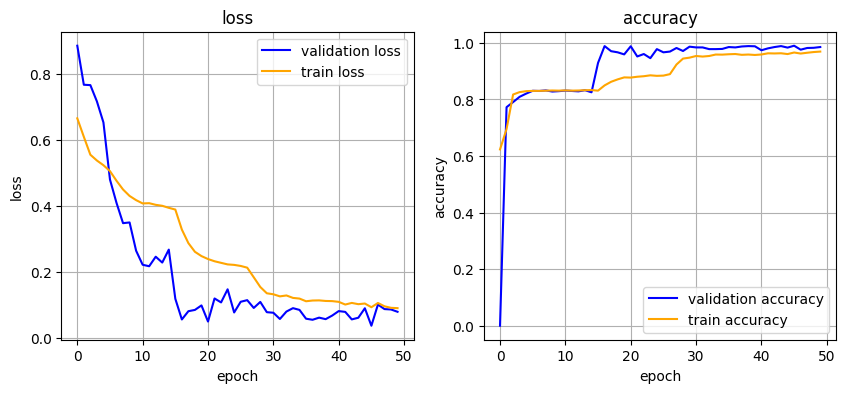

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history['val_loss'], c='blue', label='validation loss')
ax[0].plot(history.history['loss'], c='orange', label='train loss')
ax[0].set_title('loss')
ax[0].grid()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(history.history['val_acc'], c='blue', label='validation accuracy')
ax[1].plot(history.history['acc'], c='orange', label='train accuracy')
ax[1].set_title('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()


As seen from the loss and accuracy plots above, our model achieves about 99 % accuracy. This shows that our model can accurately predict sequences having both motifs within them.

### Model Interpretaion

As biologist or bioinformaticians, we are not just interested in very accurate models but also what these models actually learn. Over the past years, a lot of efforts have been made in the machine learning community towards interpratability of deep learning models. We will show two possible ways of interpreting our models.

1. By investigating the filters of the first convolutional layer. The reason for this is because at the end of training, the filters of the first convolution layer come to resemble position weight matrices (PWMs). PWMs were used traditionally to identify motifs within sequences. How this was done in the past was to scan the PWM against your sequence of interest and compute a distance metric e.g a euclidian distance. The more similar your sequence was to the PWM, the closer your euclidian distance was to zero.

2. By using DeepSHAP, an interpratation tool for deep learning models. Filters of the CNN, turn to learn features from the input data and sometimes each filter learns a part of a certain feature. Therefore, observing filters individually, may not be the best option. DeepSHAP and DeepLIFT and some packages that help with this issue. In brief, these tools backpropagate the signal from the output layer back to the corresponding nucleotides in the input sequence. As such nucleotides in the input sequence that were responsible for the models prediction on that sequence will be highlighted. The advantage of these methods is that they use the information of all neurones within the neural network, which makes them way better.

In [67]:
for layer in model.layers:
    print(layer.name)

input_4
conv1d_12
conv1d_13
max_pooling1d_3
dropout_3
conv1d_14
conv1d_15
flatten_3
dense_6
dense_7


Above are the names of the different layers within our network. We will target 'conv1d' as this is the first convolutional layer

In [68]:
filters, biases = model.layers[1].get_weights()
print(filters.shape)

(8, 4, 16)


In [69]:
from deeplift.visualization.viz_sequence import plot_weights_given_ax

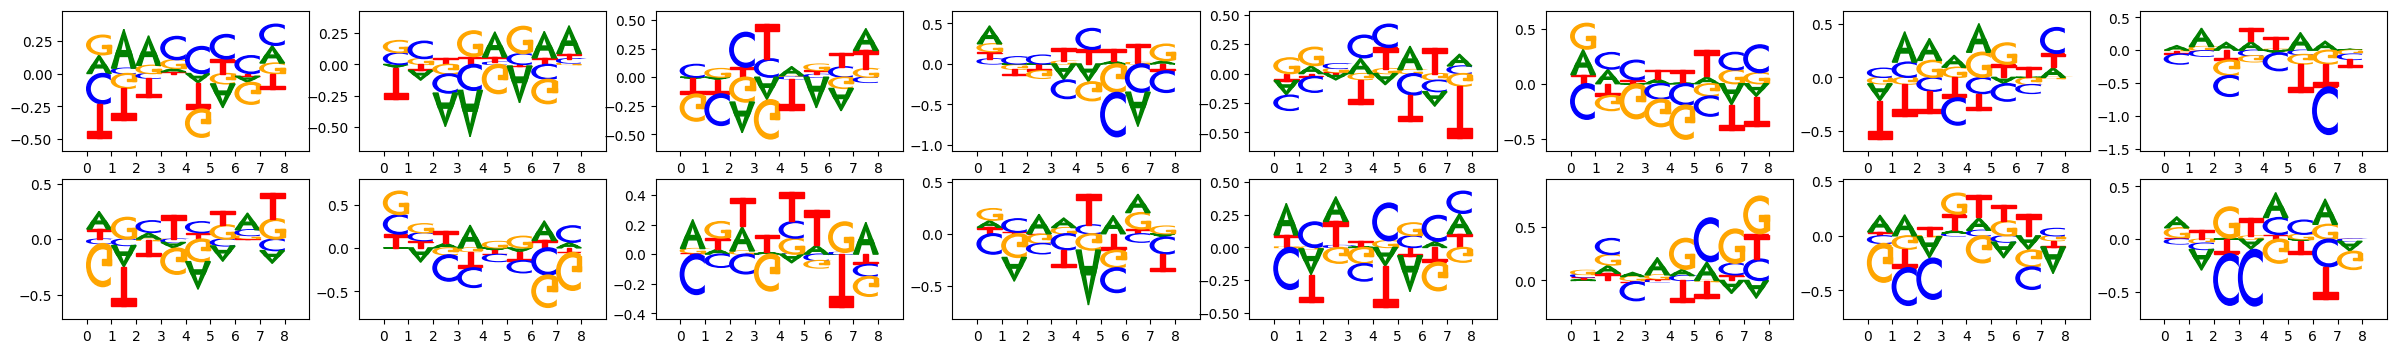

In [70]:
fig, ax = plt.subplots(2, 8, figsize=(30, 4))
ax_coords = [(i, j) for i in range(2) for j in range(8)]
for idx, ax_coord in enumerate(ax_coords):
    plot_weights_given_ax(ax=ax[ax_coord], array=filters[:, :, idx],
                     height_padding_factor=0.2,
                     length_padding=1.0,
                     subticks_frequency=1,
                     highlight={})

As you can see above, individual filters seem to learn parts of either of the motifs. Visualizing individual filters independently may not be the best way to know what our model learns. It does not look to informative. We could however use tools like deepLIFT and deepSHAP that will give us at the end a more cleaner version of what our model learns. Below we will use deepSHAP to see what our model learns.

In [71]:
# This part of this code is copied from a notebook from deepLIFT.
# It is an adapted use of deepSHAP
np.random.seed(1)


def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
  assert len(list_containing_input_modes_for_an_example)==1
  onehot_seq = list_containing_input_modes_for_an_example[0]
  rng = np.random.RandomState(seed)
  to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(20)])
  return [to_return]

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

Sequence 1
Actual contributions


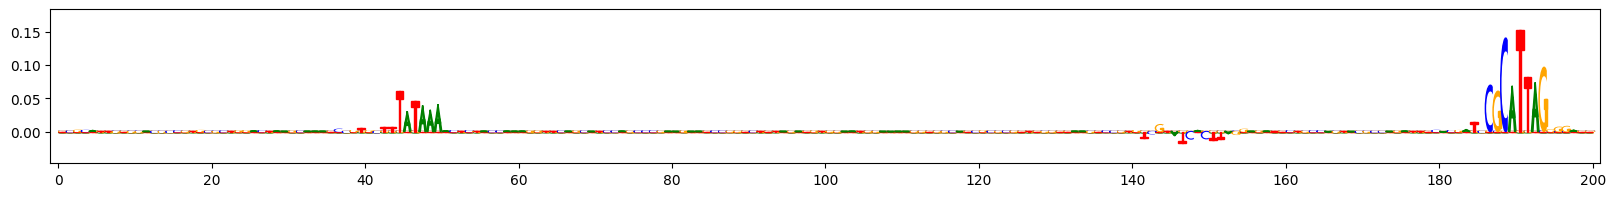

Sequence 2
Actual contributions


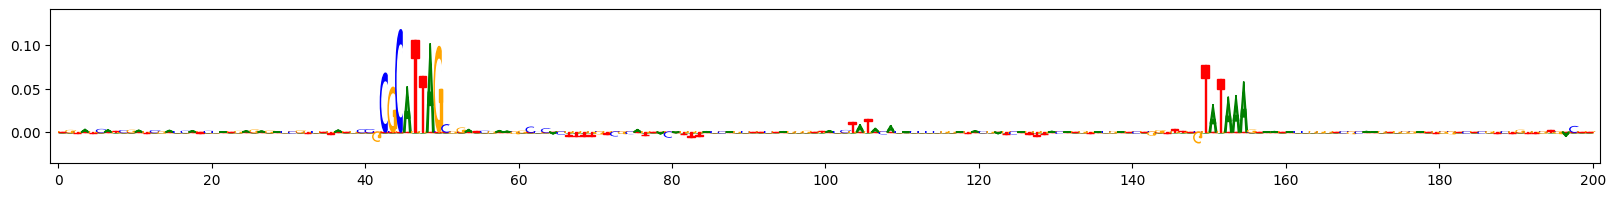

Sequence 3
Actual contributions


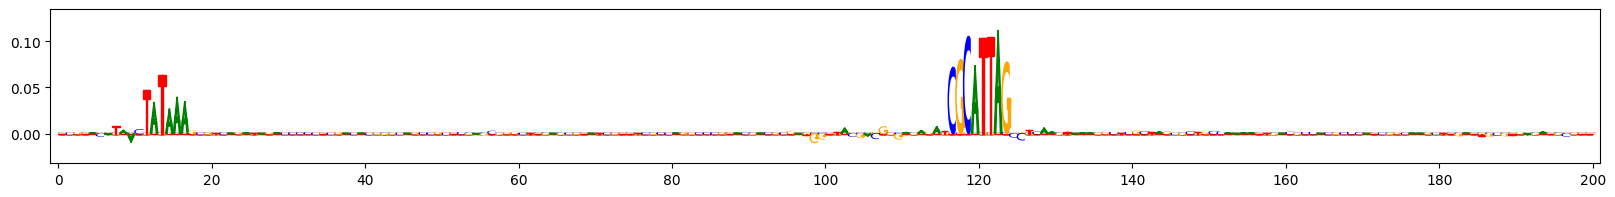

Sequence 4
Actual contributions


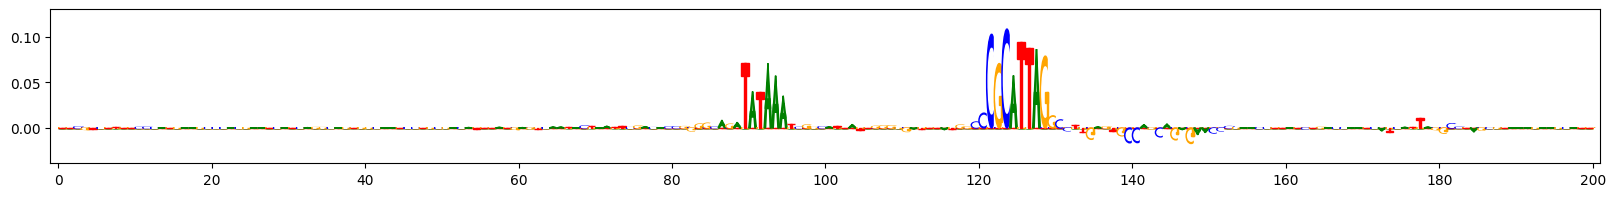

Sequence 5
Actual contributions


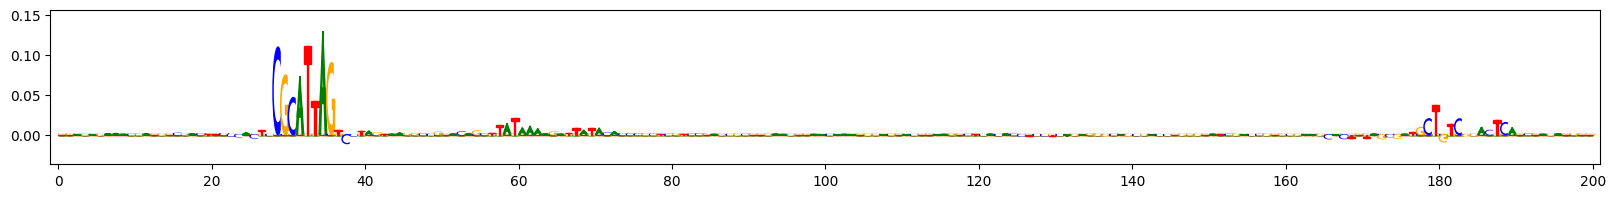

In [72]:
pos_seqs = np.where(y==1)[0]
seqs_to_explain = one_hot_x[pos_seqs[:5]]

dinuc_shuff_explainer = shap.DeepExplainer(
    (model.input, model.output[:,0]), dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

for idx,(hypimpscores,orig_seq) in enumerate(zip(shap_explanations,seqs_to_explain)):
    print("Sequence",idx+1)
    print("Actual contributions")
    viz_sequence.plot_weights(hypimpscores*orig_seq, subticks_frequency=20)

Perfect!!!
As you can see, with the deepSHAP tool, we could easily see on our sequences themselves which regions were responsible for our model's positive predictions. On every sequence, you can immediately see it was due to both motifs. The examples above are five positive sequences from our dataset. 

As a bonus, as of the creation of this notebook, there is another tool called deepLIFT that can do the same as what we have above. In fact the deepSHAP version we use here was adapted by the author of deepLIFT. So you can check it out.

There is also another package called modisco, which enables us to take these actual contributions scores above and generate motifs from them. This is out of the scope of this notebook. But just know something like that exists.